In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Load and preprocess data

In [11]:
def loadAndPreprocessData(filePath):
    data = pd.read_csv(filePath)
    data['Date_Time'] = pd.to_datetime(data['Date_Time'])
    
    data = data.drop_duplicates(subset='Date_Time').sort_values(by='Date_Time').reset_index(drop=True)
    
    data = data.set_index('Date_Time').asfreq('D')
    
    data = data.interpolate(method='time')  
    return data

### Splitting the data into training & testing 

In [12]:
def splitData(data, targetColumn, splitRatio=0.8):
    splitIndex = int(len(data) * splitRatio)
    trainData = data.iloc[:splitIndex][targetColumn]
    testData = data.iloc[splitIndex:][targetColumn]
    return trainData, testData

### Train ARIMA Model 

In [13]:
def trainArimaModel(trainData, order=(1, 1, 1)):
    model = ARIMA(trainData, order=order)
    modelFit = model.fit()
    return modelFit


In [14]:
def generateForecast(model, steps):
    forecast = model.forecast(steps=steps)
    return forecast

### Printing evaluation metrics

In [15]:
def smape(actual, forecast):
    actual = np.array(actual)
    forecast = np.array(forecast)
    numerator = np.abs(forecast - actual)
    denominator = (np.abs(actual) + np.abs(forecast)) / 2
    return 100 * np.mean(numerator / denominator)

In [16]:
def printMetrics(actual, forecast, modelName="ARIMA"):
    mse = mean_squared_error(actual, forecast)
    mad = mean_absolute_error(actual, forecast)
    smapeVal = smape(actual, forecast)
    
    print(f"\nMetrics for {modelName}:")
    print(f"\tMean Squared Error (MSE): {mse:.5f}")
    print(f"\tMean Absolute Deviation (MAD): {mad:.5f}")
    print(f"\tRoot Mean Squared Error (RMSE): {np.sqrt(mse):.5f}")
    print(f"\tSymmetric Mean Absolute Percentage Error (SMAPE): {smapeVal:.5f}")

### Plotting actual vs forecasted values

In [19]:
def plotForecastsVsActual(dates, actual, forecasted, modelName="ARIMA", temp_min=-19.97, temp_max=40.00):
    plt.figure(figsize=(10, 5))
    plt.plot(dates, actual, marker='o', linestyle='-', label='Actual')
    plt.plot(dates, forecasted, marker='o', linestyle='-', label='Forecasted')
    
    plt.axhline(y=temp_min, color='red', linestyle='--', linewidth=1, label=f'Min Temp: {temp_min:.2f}°C')
    plt.axhline(y=temp_max, color='green', linestyle='--', linewidth=1, label=f'Max Temp: {temp_max:.2f}°C')
    
    plt.title(f'Actual vs Forecasted using {modelName}')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


Metrics for ARIMA:
	Mean Squared Error (MSE): 30.89852
	Mean Absolute Deviation (MAD): 4.60299
	Root Mean Squared Error (RMSE): 5.55864
	Symmetric Mean Absolute Percentage Error (SMAPE): 13.84341


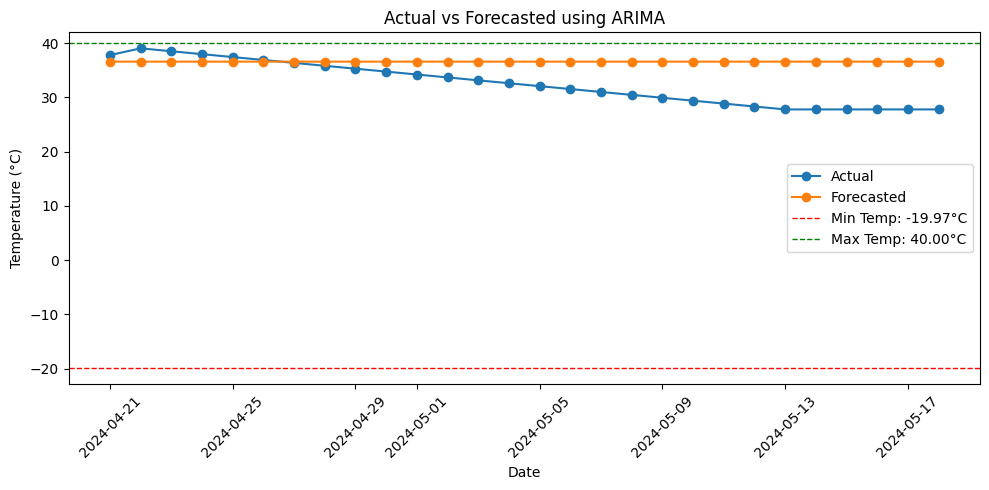

In [20]:
weatherData = loadAndPreprocessData('weather_data.csv')

trainData, testData = splitData(weatherData, targetColumn='Temperature_C')
forecastHorizon = len(testData)

arimaModel = trainArimaModel(trainData, order=(1, 1, 1))

forecast = generateForecast(arimaModel, steps=forecastHorizon)

printMetrics(testData, forecast, "ARIMA")

plotForecastsVsActual(testData.index, testData, forecast, "ARIMA")